In [6]:
import pycbc

from platform import python_version

print(python_version())
import tensorflow as tf
from tensorflow import keras
import keras
from tqdm.notebook import tqdm

import multiprocessing
multiprocessing.cpu_count()

import lhsmdu

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


3.8.6


In [7]:
from keras.models import Sequential
from keras.layers import Dense

In [8]:
from pycbc.waveform import td_approximants, fd_approximants
import pycbc.noise
import pycbc.psd

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import numpy as np

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.9.3


In [10]:
print(fd_approximants())

['EccentricFD', 'TaylorF2', 'TaylorF2Ecc', 'TaylorF2NLTides', 'TaylorF2RedSpin', 'TaylorF2RedSpinTidal', 'SpinTaylorF2', 'EOBNRv2_ROM', 'EOBNRv2HM_ROM', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBNRv2_ROM_DoubleSpin', 'SEOBNRv2_ROM_DoubleSpin_HI', 'Lackey_Tidal_2013_SEOBNRv2_ROM', 'SEOBNRv4_ROM', 'SEOBNRv4HM_ROM', 'SEOBNRv4_ROM_NRTidal', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'SEOBNRv4T_surrogate', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidal', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomP', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'SpinTaylorT4Fourier', 'SpinTaylorT5Fourier', 'NRSur4d2s', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'SpinTaylorF2_SWAPPER', 'TaylorF2NL', 'PreTaylorF2', 'multiband', 'TaylorF2_INTERP', 'SpinTaylorT5', 'SEOBNRv1_ROM_EffectiveSpin_INTERP', 'SEOBNRv1_ROM_DoubleSp

In [11]:
# Set some global variables

APPROXIMANT = 'IMRPhenomXPHM'
FLOW = 10.0
DELTA_F = 1.0 / 32
FLEN = int(2048 / DELTA_F) + 1

INTERP_GRID = np.logspace(1,3,250)
LIN_INTERP_GRID = np.arange(0,1000,DELTA_F)

In [44]:
def latin_hypercube_sampling(ndim,nsamples):
    return np.array([np.random.permutation(np.linspace(0,1,nsamples)) for i in range(ndim)])
        
    

def get_single_waveform(sample):
    samp_dict = {name:sample[name] for name in sample.dtype.names}
    hp, hc = pycbc.waveform.get_fd_waveform(approximant=APPROXIMANT,distance=1e-20,
                             f_lower=FLOW, delta_f=DELTA_F,**samp_dict)

#     x = [sample['mass2']/sample['mass1'],
#               sample['s1x'],sample['s2x'],
#               sample['s1y'],sample['s2y'],
#               sample['s1z'],sample['s2z'],
#               sample['inclination']]
    x = [sample['mass2']/sample['mass1'],
              sample['spin_mag_1'],sample['spin_mag_2'],
              sample['cos_az_ang_1'],sample['cos_az_ang_2'],
              sample['pol_ang_1'],sample['pol_ang_2'],
              sample['inclination']]
    hp_amp_interp = np.interp(INTERP_GRID,hp.sample_frequencies,np.sqrt(hp.squared_norm()))
    hc_amp_interp = np.interp(INTERP_GRID,hc.sample_frequencies,np.sqrt(hc.squared_norm()))
    hp_phase_interp = np.interp(INTERP_GRID,hp.sample_frequencies,np.unwrap(np.angle(hp)))
    hc_phase_interp = np.interp(INTERP_GRID,hc.sample_frequencies,np.unwrap(np.angle(hc)))
    y = np.concatenate((hp_amp_interp,hc_amp_interp,hp_phase_interp,hc_phase_interp))
    return x,y

def generate_waveforms(outstr='wfsamples',nsamples=2**11,seed=1234,ncores=1,sample_type='random'):
    np.random.seed(seed)

    samples_dict = {}
    total_mass = 60
    
    if sample_type == 'random':
        mass_ratios = np.random.uniform(0.1,1,size=nsamples)

        #total_masses = np.random.uniform(5,100,size=nsamples)
        
        samples_dict['mass1'] = total_mass/(1.+mass_ratios)
        samples_dict['mass2'] = total_mass-samples_dict['mass1']

        spin_mags = np.random.uniform(0,1,size=nsamples*2)
        cos_az_ang = np.random.uniform(-1,1,size=nsamples*2)
        pol_ang = np.random.uniform(0,2.*np.pi,size=nsamples*2)
        in_plane_comp = spin_mags*np.sqrt(1.-cos_az_ang**2)
        sx = in_plane_comp*np.sin(pol_ang)
        sy = in_plane_comp*np.cos(pol_ang)
        sz = spin_mags*cos_az_ang
        samples_dict['spin_mag_1'],samples_dict['spin_mag_2'] = spin_mags[:nsamples],spin_mags[nsamples:]
        samples_dict['cos_az_ang_1'],samples_dict['cos_az_ang_2'] = cos_az_ang[:nsamples],cos_az_ang[nsamples:]
        samples_dict['pol_ang_1'],samples_dict['pol_ang_2'] = pol_ang[:nsamples],pol_ang[nsamples:]
        samples_dict['s1x'],samples_dict['s2x'] = sx[:nsamples],sx[nsamples:]
        samples_dict['s1y'],samples_dict['s2y'] = sy[:nsamples],sy[nsamples:]
        samples_dict['s1z'],samples_dict['s2z'] = sz[:nsamples],sz[nsamples:]
        samples_dict['inclination'] = np.arccos(np.random.uniform(-1,1,size=nsamples))
        
    elif sample_type=='lhs':
        
        # latin hypercube sampling
        samples = latin_hypercube_sampling(8,nsamples)
        
        #masses / mass ratios
        mass_ratios = samples[0,:] - 1. # log mass ratios
        mass_ratios = 10**mass_ratios # unlog it
        #mass_ratios = samples[0,:]*0.9 + 0.1 # from 0.1 to 1
        samples_dict['mass1'] = total_mass/(1.+mass_ratios)
        samples_dict['mass2'] = total_mass-samples_dict['mass1']
        
        # spins
        samples_dict['spin_mag_1'],samples_dict['spin_mag_2'] = samples[1,:],samples[2,:]
        samples_dict['cos_az_ang_1'],samples_dict['cos_az_ang_2'] = 2.*samples[3,:] - 1 , 2.*samples[4,:] - 1
        samples_dict['pol_ang_1'],samples_dict['pol_ang_2'] = 2.*np.pi*samples[5,:], 2.*np.pi*samples[6,:]
        
        # inclination
        samples_dict['inclination'] = np.pi*samples[7,:]
        
    samples = np.array(list(zip(*[samples for _,samples in samples_dict.items()])),dtype=[(name,float) for name,_ in samples_dict.items()])


    if ncores==1:
        XYout = list(map(get_single_waveform,samples))
    else:
        print(f'multiprocessing with {ncores} cores')
        with multiprocessing.Pool(ncores) as pool:
            XYout = list(pool.map(get_single_waveform,samples,chunksize=len(samples)//ncores))


    X,Y = [XYout_line[0] for XYout_line in XYout], [XYout_line[1] for XYout_line in XYout]
    
    X = np.array(X)
    Y = np.array(Y)
    np.save(f'{outstr}_X.npy',X)
    np.save(f'{outstr}_Y.npy',Y)

    return X,Y

In [59]:
nsamples = 2**18

In [61]:
X,Y = generate_waveforms(nsamples=nsamples,ncores=16,sample_type='random')

multiprocessing with 16 cores


In [62]:
X,Y = np.load('wfsamples_X.npy'),np.load('wfsamples_Y.npy')

log_amp = False
if log_amp:   
    Y[:,:500] = np.log10(Y[:,:500])

In [63]:
class Normalizer:
    def __init__(self,Ytrain,mean=1,width=1):
        self.Ymin,self.Ymax = np.min(Ytrain,axis=0), np.max(Ytrain,axis=0)
        self.Ywidth = self.Ymax - self.Ymin
        self.mean = mean
        self.width = width
        
    def whiten(self,Ytrain):
        return (Ytrain - (self.Ymax+self.Ymin)/2.) * self.width/self.Ywidth
    
    def color(self,Ypred):
        return Ypred * (self.Ywidth/self.width) + (self.Ymax+self.Ymin)/2.
    
def calc_mismatch(y1_amp,y1_phase,y2_amp,y2_phase):
    # interpolate onto linear grid
    y1_amp_interp = np.interp(LIN_INTERP_GRID,INTERP_GRID,y1_amp)
    y2_amp_interp = np.interp(LIN_INTERP_GRID,INTERP_GRID,y2_amp)
    y1_phase_interp = np.interp(LIN_INTERP_GRID,INTERP_GRID,y1_phase)
    y2_phase_interp = np.interp(LIN_INTERP_GRID,INTERP_GRID,y2_phase)
    
    # convert to complex frequency series
    y1_interp = y1_amp_interp*np.exp(1j*y1_phase_interp)
    y2_interp = y2_amp_interp*np.exp(1j*y2_phase_interp)
    y1_interp = pycbc.types.frequencyseries.FrequencySeries(y1_interp,DELTA_F)
    y2_interp = pycbc.types.frequencyseries.FrequencySeries(y2_interp,DELTA_F)
    # calc match and return
    return 1. - pycbc.filter.matchedfilter.match(y1_interp,y2_interp)[0]

In [64]:
train_idx = np.random.choice(nsamples,replace=False,size=int(nsamples*0.8))
train_sel = np.zeros_like(X[:,0],dtype=bool)
train_sel[train_idx] = True
Xtrain,Ytrain = X[train_sel,:], Y[train_sel,:]
Xtest,Ytest = X[~train_sel,:], Y[~train_sel,:]


normalizer = Normalizer(Ytrain)
Ytrain = normalizer.whiten(Ytrain)
#Y = np.divide(np.subtract(Y,Ymin),Ywidth)
print(Xtrain.shape,Ytrain.shape)
print(Xtest.shape,Ytest.shape)

(209715, 8) (209715, 1000)
(52429, 8) (52429, 1000)


In [27]:
model = Sequential()
model.add(Dense(500, input_dim=8, activation='tanh'))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(128, activation='relu'))
model.add(Dense(1000, activation='linear'))
model.compile(loss="mean_squared_error", optimizer='adam',metrics=["mean_squared_error"])

In [223]:
model.fit(Xtrain,Ytrain,epochs=200,batch_size=1000);

Epoch 1/200
53/53 [==============================] - 1s 11ms/step - loss: 0.0647 - mean_squared_error: 0.0647
Epoch 2/200
53/53 [==============================] - 1s 11ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 3/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 4/200
53/53 [==============================] - 1s 11ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 5/200
53/53 [==============================] - 1s 11ms/step - loss: 0.0315 - mean_squared_error: 0.0315
Epoch 6/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 7/200
53/53 [==============================] - 1s 11ms/step - loss: 0.0315 - mean_squared_error: 0.0315
Epoch 8/200
53/53 [==============================] - 1s 11ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 9/200
53/53 [==============================] - 1s 12ms/step - loss: 0.0314 - mean_squared_error: 0.0314
Epoch 10/2

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 148/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 149/200
53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 150/200
53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 151/200
53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 152/200
53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 153/200
53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 154/200
53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 155/200
53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 

In [224]:
_, accuracy = model.evaluate(Xtrain,Ytrain)
print('Accuracy: %.2f' % (accuracy*100))

1639/1639 [==============================] - 3s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Accuracy: 0.31


In [225]:
y_pred = model.predict(Xtest)

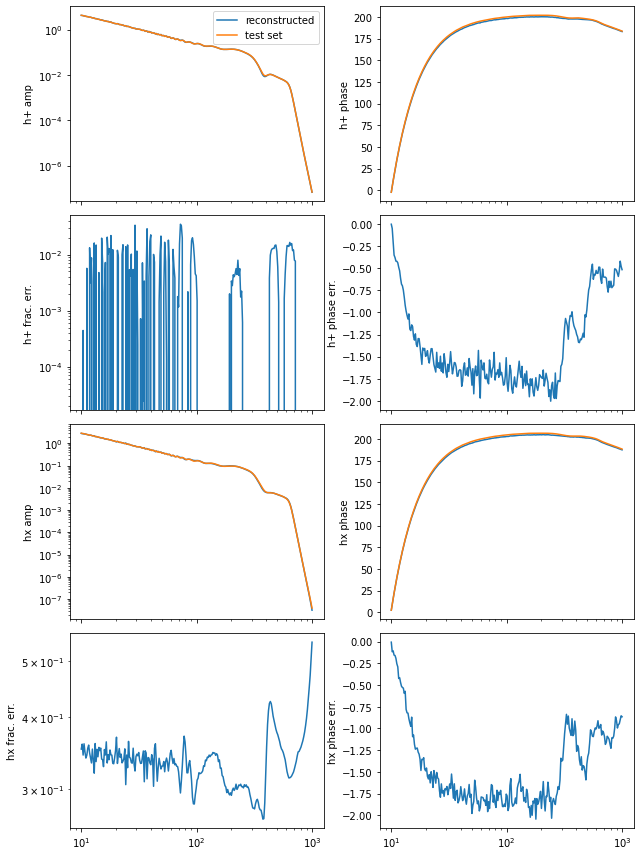

In [308]:

Yreconst = normalizer.color(y_pred)
Ytest_reconst = Ytest
if log_amp:
    Yreconst[:,:500] = 10**Yreconst[:,:500]
    Ytest_reconst[:,:500] = 10**Ytest_reconst[:,:500]

def plot_reconst(i):
    fig,ax = plt.subplots(4,2,sharex=True,figsize=(9,12))
    ax[0,0].set_ylabel('h+ amp')
    ax[0,0].loglog(INTERP_GRID,Yreconst[i,:250],label='reconstructed')
    ax[0,0].loglog(INTERP_GRID,Ytest_reconst[i,:250],label='test set')
    ax[0,0].legend()
    
    ax[1,0].set_ylabel('h+ frac. err.')
    ax[1,0].loglog(INTERP_GRID,(Yreconst[i,:250] - Ytest_reconst[i,:250])/Ytest_reconst[i,:250])
    
    ax[2,0].set_ylabel('hx amp')
    ax[2,0].loglog(INTERP_GRID,Yreconst[i,250:500],label='reconstructed')
    ax[2,0].loglog(INTERP_GRID,Ytest_reconst[i,250:500],label='test set')
    
    ax[3,0].set_ylabel('hx frac. err.')
    ax[3,0].loglog(INTERP_GRID,np.abs((Yreconst[i,250:500] - Ytest_reconst[i,:250])/Ytest_reconst[i,:250]))
    
    ax[0,1].set_ylabel('h+ phase')
    ax[0,1].semilogx(INTERP_GRID,Yreconst[i,500:750],label='reconstructed')
    ax[0,1].semilogx(INTERP_GRID,Ytest_reconst[i,500:750],label='test set')
    
    ax[1,1].set_ylabel('h+ phase err.')
    ax[1,1].semilogx(INTERP_GRID,Yreconst[i,500:750] - Ytest_reconst[i,500:750])
    
    ax[2,1].set_ylabel('hx phase')
    ax[2,1].semilogx(INTERP_GRID,Yreconst[i,750:1000],label='reconstructed')
    ax[2,1].semilogx(INTERP_GRID,Ytest_reconst[i,750:1000],label='test set')
    
    ax[3,1].set_ylabel('hx phase err.')
    ax[3,1].semilogx(INTERP_GRID,Yreconst[i,750:1000] - Ytest_reconst[i,750:1000])
    
    fig.tight_layout()
    
plot_reconst(31)
#plt.semilogx(interp_grid,Yreconst[i,500:750],label='reconstructed')
#plt.semilogx(interp_grid,Ytest[i,500:750],label='test set')
#plt.legend()

## try with multiple networks, one for amplitudes and one for phases

In [65]:
model_phase = Sequential()
model_phase.add(Dense(8, input_dim=8, activation='tanh'))
model_phase.add(Dense(256, activation='tanh'))
#model.add(Dense(128, activation='relu'))
model_phase.add(Dense(500, activation='linear'))
model_phase.compile(loss="mean_squared_error", optimizer='adam',metrics=["mean_squared_error"])

model_amp = Sequential()
model_amp.add(Dense(8, input_dim=8, activation='tanh'))
model_amp.add(Dense(128, activation='tanh'))
model_amp.add(Dense(256, activation='tanh'))
#model.add(Dense(128, activation='relu'))
model_amp.add(Dense(500, activation='linear'))
model_amp.compile(loss="mean_squared_error", optimizer='adam',metrics=["mean_squared_error"])

In [74]:
history_amp = model_amp.fit(Xtrain,Ytrain[:,:500],epochs=200,batch_size=64);
history_phase = model_phase.fit(Xtrain,Ytrain[:,500:],epochs=200,batch_size=64);

Epoch 1/200
3277/3277 [==============================] - 10s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 2/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3/200
3277/3277 [==============================] - 11s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 4/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 5/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 6/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 7/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 8/200
3277/3277 [==============================] - 10s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 9/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0012 - m

3277/3277 [==============================] - 11s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 73/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 74/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 75/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 76/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 77/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 78/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 79/200
3277/3277 [==============================] - 12s 4ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 80/200
3277/3277 [==============================] - 11s 4ms/step - loss: 0.0011 - mean_

Epoch 143/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 144/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 145/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 146/200
3277/3277 [==============================] - 10s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 147/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 148/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 149/200
3277/3277 [==============================] - 10s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 150/200
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 151/200
3277/3277 [==============================] - 11s 3ms/step 

3277/3277 [==============================] - 9s 3ms/step - loss: 5.1265e-05 - mean_squared_error: 5.1265e-05
Epoch 14/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.1212e-05 - mean_squared_error: 5.1212e-05
Epoch 15/200
3277/3277 [==============================] - 8s 3ms/step - loss: 5.1142e-05 - mean_squared_error: 5.1142e-05
Epoch 16/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.1366e-05 - mean_squared_error: 5.1366e-05
Epoch 17/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.1134e-05 - mean_squared_error: 5.1134e-05
Epoch 18/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.1299e-05 - mean_squared_error: 5.1299e-05
Epoch 19/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.1084e-05 - mean_squared_error: 5.1084e-05
Epoch 20/200
3277/3277 [==============================] - 8s 3ms/step - loss: 5.1000e-05 - mean_squared_error: 5.1000e-05
Epoch 21/200
3277/3277 [=============

3277/3277 [==============================] - 9s 3ms/step - loss: 5.1098e-05 - mean_squared_error: 5.1098e-05
Epoch 81/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.0980e-05 - mean_squared_error: 5.0980e-05
Epoch 82/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.0890e-05 - mean_squared_error: 5.0890e-05
Epoch 83/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.1103e-05 - mean_squared_error: 5.1103e-05
Epoch 84/200
3277/3277 [==============================] - 8s 2ms/step - loss: 5.1129e-05 - mean_squared_error: 5.1129e-05
Epoch 85/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.0926e-05 - mean_squared_error: 5.0926e-05
Epoch 86/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.1070e-05 - mean_squared_error: 5.1070e-05
Epoch 87/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.0797e-05 - mean_squared_error: 5.0797e-05
Epoch 88/200
3277/3277 [=============

3277/3277 [==============================] - 8s 3ms/step - loss: 5.0813e-05 - mean_squared_error: 5.0813e-05
Epoch 147/200
3277/3277 [==============================] - 10s 3ms/step - loss: 5.0988e-05 - mean_squared_error: 5.0988e-05
Epoch 148/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.0494e-05 - mean_squared_error: 5.0494e-05
Epoch 149/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.0981e-05 - mean_squared_error: 5.0981e-05
Epoch 150/200
3277/3277 [==============================] - 9s 3ms/step - loss: 5.0509e-05 - mean_squared_error: 5.0509e-05
Epoch 151/200
3277/3277 [==============================] - 8s 3ms/step - loss: 5.0774e-05 - mean_squared_error: 5.0774e-05
Epoch 152/200
3277/3277 [==============================] - 10s 3ms/step - loss: 5.0824e-05 - mean_squared_error: 5.0824e-05
Epoch 153/200
3277/3277 [==============================] - 8s 3ms/step - loss: 5.0820e-05 - mean_squared_error: 5.0820e-05
Epoch 154/200
3277/3277 [===

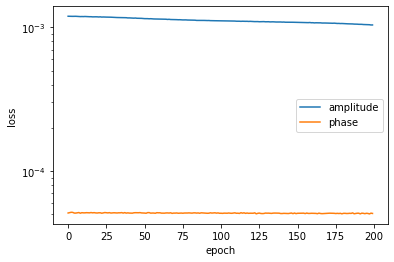

In [75]:
plt.semilogy(history_amp.history['loss'],label='amplitude')
plt.semilogy(history_phase.history['loss'],label='phase')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [76]:
y_amp_pred = model_amp.predict(Xtest)
y_phase_pred = model_phase.predict(Xtest)
y_pred = np.concatenate((y_amp_pred,y_phase_pred),axis=1)
print(y_pred.shape)

(52429, 1000)


0.01235395462137312 0.01564041028234786


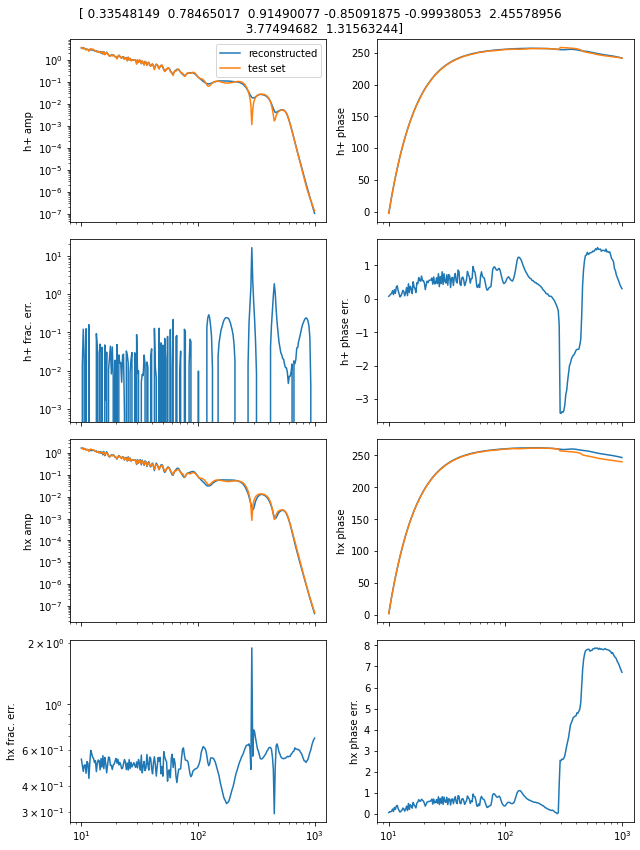

In [77]:

Yreconst = normalizer.color(y_pred)
if log_amp:
    Yreconst[:,:500] = 10**Yreconst[:,:500]
def plot_reconst(i):
    fig,ax = plt.subplots(4,2,sharex=True,figsize=(9,12))
    ax[0,0].set_ylabel('h+ amp')
    ax[0,0].loglog(INTERP_GRID,Yreconst[i,:250],label='reconstructed')
    ax[0,0].loglog(INTERP_GRID,Ytest[i,:250],label='test set')
    ax[0,0].legend()
    
    ax[1,0].set_ylabel('h+ frac. err.')
    ax[1,0].loglog(INTERP_GRID,(Yreconst[i,:250] - Ytest[i,:250])/Ytest[i,:250])
    
    ax[2,0].set_ylabel('hx amp')
    ax[2,0].loglog(INTERP_GRID,Yreconst[i,250:500],label='reconstructed')
    ax[2,0].loglog(INTERP_GRID,Ytest[i,250:500],label='test set')
    
    ax[3,0].set_ylabel('hx frac. err.')
    ax[3,0].loglog(INTERP_GRID,np.abs((Yreconst[i,250:500] - Ytest[i,:250])/Ytest[i,:250]))
    
    ax[0,1].set_ylabel('h+ phase')
    ax[0,1].semilogx(INTERP_GRID,Yreconst[i,500:750],label='reconstructed')
    ax[0,1].semilogx(INTERP_GRID,Ytest[i,500:750],label='test set')
    
    ax[1,1].set_ylabel('h+ phase err.')
    ax[1,1].semilogx(INTERP_GRID,Yreconst[i,500:750] - Ytest[i,500:750])
    
    ax[2,1].set_ylabel('hx phase')
    ax[2,1].semilogx(INTERP_GRID,Yreconst[i,750:1000],label='reconstructed')
    ax[2,1].semilogx(INTERP_GRID,Ytest[i,750:1000],label='test set')
    
    ax[3,1].set_ylabel('hx phase err.')
    ax[3,1].semilogx(INTERP_GRID,Yreconst[i,750:1000] - Ytest[i,750:1000])
    
    
    fig.suptitle('{}'.format(Xtest[i,:]))
    fig.tight_layout()

    hp_MM = calc_mismatch(Yreconst[i,:250],Yreconst[i,500:750],Ytest[i,:250],Ytest[i,500:750])
    hx_MM = calc_mismatch(Yreconst[i,250:500],Yreconst[i,750:],Ytest[i,250:500],Ytest[i,750:])

    print(hp_MM,hx_MM)
plot_reconst(406)
#plt.semilogx(interp_grid,Yreconst[i,500:750],label='reconstructed')
#plt.semilogx(interp_grid,Ytest[i,500:750],label='test set')
#plt.legend()

In [78]:
#def get_MMs(i):
#    return calc_mismatch(Yreconst[i,:250],Yreconst[i,500:750],Ytest[i,:250],Ytest[i,500:750]), calc_mismatch(Yreconst[i,250:500],Yreconst[i,750:],Ytest[i,250:500],Ytest[i,750:])

#with multiprocessing.Pool(4) as pool:
#    MMs = np.array(list(pool.map(get_MMs,range(Yreconst.shape[0]))),dtype=float,names='hp,hx')
hpMMs = []
hxMMs = []
for i in range(Yreconst.shape[0]):
    hpMMs.append(calc_mismatch(Yreconst[i,:250],Yreconst[i,500:750],Ytest[i,:250],Ytest[i,500:750]))
    hxMMs.append(calc_mismatch(Yreconst[i,250:500],Yreconst[i,750:],Ytest[i,250:500],Ytest[i,750:]))

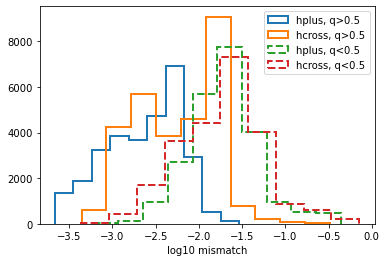

In [79]:
loghpMMs = np.log10(hpMMs)
loghxMMs = np.log10(hxMMs)
sel = Xtest[:,0]>0.5
plt.hist(loghpMMs[sel],histtype='step',label='hplus, q>0.5',lw=2)
plt.hist(loghxMMs[sel],histtype='step',label='hcross, q>0.5',lw=2)
plt.hist(loghpMMs[~sel],histtype='step',label='hplus, q<0.5',lw=2,ls='--')
plt.hist(loghxMMs[~sel],histtype='step',label='hcross, q<0.5',lw=2,ls='--')
plt.xlabel('log10 mismatch')
plt.legend()